## Notebook-Dokumentation
- Lädt alle CSVs aus `raw_data/citi_bike/2023-2025` (lazy scan mit Polars) und prüft Zeitraum/Zeilenanzahl.
- Kontrolliert fehlende Werte in Koordinaten/Zeitspalten und Basisverteilungen (rideable/member/bike type).
- Grober Qualitätscheck bevor weitere Analysen starten.


Sammelt alle Citi-Bike-CSV-Pfade (2023–2025), zählt Dateien und berechnet Gesamtgröße; zeigt die ersten Pfad-Einträge.

In [1]:
# Collect raw CSV paths and total size
from pathlib import Path

DATA_DIR = Path("../../raw_data/citi_bike")
FILES = (sorted(DATA_DIR.glob("2023-citibike-tripdata/*.csv")) 
    + sorted(DATA_DIR.glob("2024-citibike-tripdata/*.csv")) 
    + sorted(DATA_DIR.glob("2025-citibike-tripdata/*.csv")))


print(f"files: {len(FILES)}")
total_gb = sum(p.stat().st_size for p in FILES) / 1e9
print(f"total size: {total_gb:.2f} GB")
FILES[:5]


files: 143
total size: 24.47 GB


[PosixPath('../../raw_data/citi_bike/2023-citibike-tripdata/202301-citibike-tripdata_1.csv'),
 PosixPath('../../raw_data/citi_bike/2023-citibike-tripdata/202301-citibike-tripdata_2.csv'),
 PosixPath('../../raw_data/citi_bike/2023-citibike-tripdata/202302-citibike-tripdata_1.csv'),
 PosixPath('../../raw_data/citi_bike/2023-citibike-tripdata/202302-citibike-tripdata_2.csv'),
 PosixPath('../../raw_data/citi_bike/2023-citibike-tripdata/202303-citibike-tripdata_1.csv')]

Definiert das Polars-Schema, baut einen Lazy-Scan über alle CSVs; Ausgabe ist die LazyFrame-Repräsentation.

In [2]:
# Define schema and lazily scan CSV files
import polars as pl

SCHEMA = {
    "ride_id": pl.Utf8,
    "rideable_type": pl.Utf8,
    "started_at": pl.Datetime,
    "ended_at": pl.Datetime,
    "start_station_name": pl.Utf8,
    "start_station_id": pl.Utf8,
    "end_station_name": pl.Utf8,
    "end_station_id": pl.Utf8,
    "start_lat": pl.Float64,
    "start_lng": pl.Float64,
    "end_lat": pl.Float64,
    "end_lng": pl.Float64,
    "member_casual": pl.Utf8,
}

scan = pl.scan_csv([str(p) for p in FILES], schema=SCHEMA, try_parse_dates=True, ignore_errors=True)
scan


Aggregiert Basis-Kennzahlen (Zeilen, eindeutige ride_id, min/max Start-/Endzeiten) und zeigt die Übersichtstabelle.

In [3]:
# Basic dataset stats and time range
overview = scan.select(
    [
        pl.len().alias("rows"),
        pl.col("ride_id").n_unique().alias("unique_ride_id"),
        pl.col("started_at").min().alias("started_min"),
        pl.col("started_at").max().alias("started_max"),
        pl.col("ended_at").min().alias("ended_min"),
        pl.col("ended_at").max().alias("ended_max"),
    ]
).collect()
overview


shape: (1, 6)
┌───────────┬────────────────┬─────────────────┬─────────────────┬────────────────┬────────────────┐
│ rows      ┆ unique_ride_id ┆ started_min     ┆ started_max     ┆ ended_min      ┆ ended_max      │
│ ---       ┆ ---            ┆ ---             ┆ ---             ┆ ---            ┆ ---            │
│ u32       ┆ u32            ┆ datetime[μs]    ┆ datetime[μs]    ┆ datetime[μs]   ┆ datetime[μs]   │
╞═══════════╪════════════════╪═════════════════╪═════════════════╪════════════════╪════════════════╡
│ 125181297 ┆ 125181297      ┆ 2022-12-14      ┆ 2025-12-31      ┆ 2023-01-01     ┆ 2025-12-31     │
│           ┆                ┆ 11:43:54.762    ┆ 23:57:28.999    ┆ 00:00:07.185   ┆ 23:59:58.372   │
└───────────┴────────────────┴─────────────────┴─────────────────┴────────────────┴────────────────┘

Entfernt die Spalte ride_id, da sie der Zeilenanzahl entspricht, also keinen wirklichen Nutzen für unsere Analyse hat.

In [4]:
# drop unique_ride_id column as it matches rows count
scan = scan.drop("ride_id")

Aggregiert Fahrten nach member_type und rideable_type und und zeichnet zwei Balkendiagramme zu den Häufigkeiten.

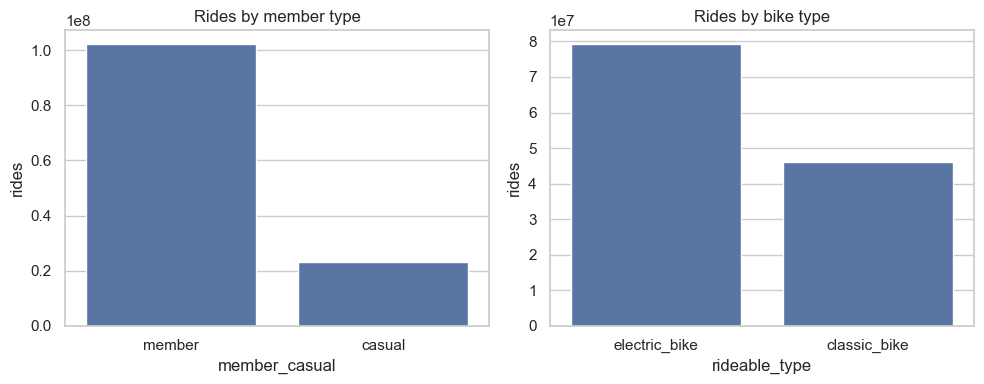

In [12]:
# Plot ride counts by member type and bike type
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

member_counts = (
    scan.group_by("member_casual")
    .agg(pl.len().alias("rides"))
    .sort("rides", descending=True)
    .collect()
    .to_pandas()
)
rideable_counts = (
    scan.group_by("rideable_type")
    .agg(pl.len().alias("rides"))
    .sort("rides", descending=True)
    .collect()
    .to_pandas()
)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(data=member_counts, x="member_casual", y="rides", ax=axes[0])
axes[0].set_title("Rides by member type")
axes[0].set_xlabel("member_casual")
axes[0].set_ylabel("rides")

sns.barplot(data=rideable_counts, x="rideable_type", y="rides", ax=axes[1])
axes[1].set_title("Rides by bike type")
axes[1].set_xlabel("rideable_type")
axes[1].set_ylabel("rides")
plt.tight_layout()


Zeigt einen kleinen Vorschau-Ausschnitt (5 Zeilen) der Daten zur Plausibilitätskontrolle.

In [13]:
# Preview sample rows
scan.limit(5).collect()


shape: (5, 12)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ rideable_ ┆ started_a ┆ ended_at  ┆ start_sta ┆ … ┆ start_lng ┆ end_lat   ┆ end_lng   ┆ member_c │
│ type      ┆ t         ┆ ---       ┆ tion_name ┆   ┆ ---       ┆ ---       ┆ ---       ┆ asual    │
│ ---       ┆ ---       ┆ datetime[ ┆ ---       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---      │
│ str       ┆ datetime[ ┆ μs]       ┆ str       ┆   ┆           ┆           ┆           ┆ str      │
│           ┆ μs]       ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ classic_b ┆ 2023-01-0 ┆ 2023-01-0 ┆ E 1 St &  ┆ … ┆ -73.99213 ┆ 40.711464 ┆ -74.00552 ┆ casual   │
│ ike       ┆ 3 23:14:5 ┆ 3 23:33:4 ┆ Bowery    ┆   ┆ 1         ┆           ┆ 4         ┆          │
│           ┆ 2.325     ┆ 2.737     ┆           ┆   ┆           ┆           ┆           ┆          │
│ electric_ ┆ 2023-01-0 ┆ 2023-01-0 ┆ E 1 St &  ┆ … ┆ -73.99213 ┆ 40.728547 ┆ -73.98175 ┆ casual   │
│ bike      ┆ 7 07:57:4 ┆ 7 08:01:2 ┆ Bowery    ┆   ┆ 1         ┆           ┆ 9         ┆          │
│           ┆ 0.054     ┆ 7.330     ┆           ┆   ┆           ┆           ┆           ┆          │
│ electric_ ┆ 2023-01-0 ┆ 2023-01-0 ┆ 1 Ave & E ┆ … ┆ -73.97113 ┆ 40.731393 ┆ -73.98286 ┆ member   │
│ bike      ┆ 9 18:37:4 ┆ 9 18:48:5 ┆ 39 St     ┆   ┆           ┆           ┆ 7         ┆          │
│           ┆ 4.830     ┆ 6.233     ┆           ┆   ┆           ┆           ┆           ┆          │
│ electric_ ┆ 2023-01-0 ┆ 2023-01-0 ┆ E         ┆ … ┆ -73.90131 ┆ 40.850535 ┆ -73.90131 ┆ casual   │
│ bike      ┆ 5 19:06:1 ┆ 5 19:08:3 ┆ Burnside  ┆   ┆ 8         ┆           ┆ 8         ┆          │
│           ┆ 5.350     ┆ 3.547     ┆ Ave &     ┆   ┆           ┆           ┆           ┆          │
│           ┆           ┆           ┆ Ryer Ave  ┆   ┆           ┆           ┆           ┆          │
│ electric_ ┆ 2023-01-0 ┆ 2023-01-0 ┆ Clermont  ┆ … ┆ -73.97129 ┆ 40.695734 ┆ -73.97129 ┆ casual   │
│ bike      ┆ 2 20:25:2 ┆ 3 10:51:2 ┆ Ave &     ┆   ┆ 7         ┆           ┆ 7         ┆          │
│           ┆ 3.300     ┆ 5.164     ┆ Park Ave  ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

Berechnet alle eindeutigen Start- und Endstationen, gibt die Anzahl aus und erzeugt eine Folium-Karte mit Marker-Cluster (interaktive Ausgabe im Notebook).

In [5]:
import folium
from folium.plugins import MarkerCluster

# Plot all unique start and end stations on a map

# Collect unique start and end stations with coordinates
stations = scan.select([
    pl.col("start_station_name").alias("station_name"),
    pl.col("start_lat").alias("lat"),
    pl.col("start_lng").alias("lng"),
]).unique().filter(
    pl.col("lat").is_not_null() & pl.col("lng").is_not_null()
).collect()

end_stations = scan.select([
    pl.col("end_station_name").alias("station_name"),
    pl.col("end_lat").alias("lat"),
    pl.col("end_lng").alias("lng"),
]).unique().filter(
    pl.col("lat").is_not_null() & pl.col("lng").is_not_null()
).collect()

# Combine and deduplicate
all_stations = pl.concat([stations, end_stations]).unique(subset=["station_name", "lat", "lng"])

print(f"Total unique stations: {len(all_stations)}")

# Create map centered on NYC
center_lat = all_stations["lat"].mean()
center_lng = all_stations["lng"].mean()
m = folium.Map(location=[center_lat, center_lng], zoom_start=12)

# Add marker cluster for better performance
marker_cluster = MarkerCluster().add_to(m)

# Add stations to map
for row in all_stations.iter_rows(named=True):
    folium.Marker(
        location=[row["lat"], row["lng"]],
        popup=row["station_name"],
        icon=folium.Icon(color="blue", icon="info-sign")
    ).add_to(marker_cluster)

m

Total unique stations: 3669
